# Cell 1: Environment Setup & Installations


In [ ]:
# Install required packages
!pip install -q sentence-transformers faiss-cpu pandas numpy scikit-learn matplotlib seaborn tqdm
!pip install -q transformers torch

# Verify installations
import sentence_transformers
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

print("All packages installed successfully")
print(f"FAISS version: {faiss.__version__}")
print(f"SentenceTransformers version: {sentence_transformers.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 117.2 MB/s eta 0:00:00
All packages installed successfully
FAISS version: 1.13.2
SentenceTransformers version: 5.2.0


# Cell 2: Load and Explore Dataset


In [ ]:
DATASET_PATH = '/content/IMDB Dataset.csv'
df = pd.read_csv(DATASET_PATH)
print(f"Dataset loaded successfully from: {DATASET_PATH}")

# Basic exploration
print("Dataset Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nFirst 3 rows:")
print(df.head(3))
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset loaded successfully from: /content/IMDB Dataset.csv
Dataset Shape: (50000, 2)

Column Names: ['review', 'sentiment']

First 3 rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive

Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Missing Values:
review       0
sentiment    0
dtype: int64


# Cell 3: Data Preprocessing


In [ ]:
# Data cleaning and preprocessing
def preprocess_text(text):
    if pd.isna(text):
        return ""
    return str(text).strip()

# Apply preprocessing
df['review_clean'] = df['review'].apply(preprocess_text)

# Remove any empty reviews
df = df[df['review_clean'].str.len() > 0].reset_index(drop=True)

print("DATA PREPROCESSING")
print(f"Total reviews after basic cleaning: {len(df):,}")

# Remove duplicate reviews
print("\nRemoving duplicate reviews...")
initial_count = len(df)
df = df.drop_duplicates(subset=['review_clean'], keep='first').reset_index(drop=True)
duplicates_removed = initial_count - len(df)

print(f"  Duplicate reviews found: {duplicates_removed:,}")
print(f"  Unique reviews remaining: {len(df):,}")
print(f"  Duplicates removed: {(duplicates_removed / initial_count * 100):.2f}%")

# Encode sentiment as binary for filtering
df['sentiment_label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

print(f"\nAverage review length: {df['review_clean'].str.len().mean():.0f} characters")
print(f"Total unique reviews: {len(df):,}")

# 90% for building the searchable database
# 10% held out for evaluation queries
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df['sentiment']
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("TRAIN/TEST SPLIT")
print(f"Training set (searchable database): {len(train_df):,} reviews")
print(f"Test set (evaluation queries): {len(test_df):,} reviews")

print(f"\nTraining set sentiment distribution:")
print(train_df['sentiment'].value_counts())
print(f"  Positive: {(train_df['sentiment'] == 'positive').sum() / len(train_df) * 100:.1f}%")
print(f"  Negative: {(train_df['sentiment'] == 'negative').sum() / len(train_df) * 100:.1f}%")

print(f"\nTest set sentiment distribution:")
print(test_df['sentiment'].value_counts())
print(f"  Positive: {(test_df['sentiment'] == 'positive').sum() / len(test_df) * 100:.1f}%")
print(f"  Negative: {(test_df['sentiment'] == 'negative').sum() / len(test_df) * 100:.1f}%")

print("\nStratified split maintains balanced sentiment distribution")
print("All duplicate reviews removed before embedding")

# Display sample from both sets
print("\nSample from Training Set:")
display(train_df[['review_clean', 'sentiment']].head(3))

print("\nSample from Test Set:")
display(test_df[['review_clean', 'sentiment']].head(3))

DATA PREPROCESSING
Total reviews after basic cleaning: 50,000

Removing duplicate reviews...
  Duplicate reviews found: 418
  Unique reviews remaining: 49,582
  Duplicates removed: 0.84%

Average review length: 1311 characters
Total unique reviews: 49,582
TRAIN/TEST SPLIT
Training set (searchable database): 44,623 reviews
Test set (evaluation queries): 4,959 reviews

Training set sentiment distribution:
sentiment
positive    22395
negative    22228
Name: count, dtype: int64
  Positive: 50.2%
  Negative: 49.8%

Test set sentiment distribution:
sentiment
positive    2489
negative    2470
Name: count, dtype: int64
  Positive: 50.2%
  Negative: 49.8%

Stratified split maintains balanced sentiment distribution
All duplicate reviews removed before embedding

Sample from Training Set:


,review_clean,sentiment
0,I'm afraid that you'll find that the huge majo...,negative
1,This was on the 30th Anniversary DVD for Blazi...,negative
2,"I'd never heard of this, then found out it's t...",negative



Sample from Test Set:


,review_clean,sentiment
0,"_Saltmen_ is a long film for its genre, and qu...",positive
1,"In Iran, women are not admitted to soccer game...",positive
2,I really hope that Concorde/New Horizons wasn'...,negative


# Cell 4: Generate Embeddings


In [ ]:
from sentence_transformers import SentenceTransformer

# Load embedding model
print("LOADING EMBEDDING MODEL")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"Model loaded: all-MiniLM-L6-v2")
print(f"Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")

# Generate embeddings for TRAINING SET (searchable database)
print("GENERATING EMBEDDINGS FOR TRAINING SET")
print(f"Processing {len(train_df):,} training reviews...")
batch_size = 256

embeddings_train = embedding_model.encode(
    train_df['review_clean'].tolist(),
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"\nTraining embeddings generated")
print(f"  Shape: {embeddings_train.shape}")
print(f"  Memory usage: {embeddings_train.nbytes / 1024**2:.2f} MB")

# Generate embeddings for TEST SET (evaluation queries)
print("GENERATING EMBEDDINGS FOR TEST SET")
print(f"Processing {len(test_df):,} test reviews...")

embeddings_test = embedding_model.encode(
    test_df['review_clean'].tolist(),
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"\nTest embeddings generated")
print(f"  Shape: {embeddings_test.shape}")
print(f"  Memory usage: {embeddings_test.nbytes / 1024**2:.2f} MB")

# Normalize embeddings for cosine similarity
embeddings_train_normalized = embeddings_train / np.linalg.norm(embeddings_train, axis=1, keepdims=True)
embeddings_test_normalized = embeddings_test / np.linalg.norm(embeddings_test, axis=1, keepdims=True)

print("EMBEDDINGS SUMMARY")
print(f"Training embeddings: {embeddings_train_normalized.shape}")
print(f"Test embeddings: {embeddings_test_normalized.shape}")
print(f"Total memory: {(embeddings_train_normalized.nbytes + embeddings_test_normalized.nbytes) / 1024**2:.2f} MB")
print("All embeddings normalized for cosine similarity")

LOADING EMBEDDING MODEL


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded: all-MiniLM-L6-v2
Embedding dimension: 384
GENERATING EMBEDDINGS FOR TRAINING SET
Processing 44,623 training reviews...


Batches:   0%|          | 0/175 [00:00<?, ?it/s]


Training embeddings generated
  Shape: (44623, 384)
  Memory usage: 65.37 MB
GENERATING EMBEDDINGS FOR TEST SET
Processing 4,959 test reviews...


Batches:   0%|          | 0/20 [00:00<?, ?it/s]


Test embeddings generated
  Shape: (4959, 384)
  Memory usage: 7.26 MB
EMBEDDINGS SUMMARY
Training embeddings: (44623, 384)
Test embeddings: (4959, 384)
Total memory: 72.63 MB
All embeddings normalized for cosine similarity


# Cell 5: Build FAISS Indexes


In [ ]:
# Build multiple FAISS indexes for comparison
print("BUILDING FAISS INDEXES (4 TYPES)")

dimension = embeddings_train_normalized.shape[1]
n_vectors = len(embeddings_train_normalized)

print(f"Dimension: {dimension}")
print(f"Number of vectors: {n_vectors:,}")
print(f"Building indexes on training set only...\n")

# 1. FlatL2 (Exact Search - L2 Distance)
print("1. Building FlatL2 (Exact Search - L2 Distance)...")
index_flatl2 = faiss.IndexFlatL2(dimension)
index_flatl2.add(embeddings_train_normalized)
print(f"   FlatL2 index built. Total vectors: {index_flatl2.ntotal:,}\n")

# 2. IVF (Inverted File Index with Flat quantizer)
print("2. Building IVF (Inverted File Index)...")
nlist = 100
quantizer_ivf = faiss.IndexFlatL2(dimension)
index_ivf = faiss.IndexIVFFlat(quantizer_ivf, dimension, nlist, faiss.METRIC_L2)
print(f"   Training IVF with {nlist} clusters...")
index_ivf.train(embeddings_train_normalized)
index_ivf.add(embeddings_train_normalized)
index_ivf.nprobe = 10
print(f"   IVF index built. Total vectors: {index_ivf.ntotal:,}")
print(f"   nprobe set to: {index_ivf.nprobe}\n")

# 3. HNSW (Hierarchical Navigable Small World)
print("3. Building HNSW (Hierarchical Navigable Small World)...")
M = 32
index_hnsw = faiss.IndexHNSWFlat(dimension, M)
index_hnsw.hnsw.efConstruction = 40
index_hnsw.hnsw.efSearch = 16
index_hnsw.add(embeddings_train_normalized)
print(f"   HNSW index built. Total vectors: {index_hnsw.ntotal:,}")
print(f"   M={M}, efConstruction={index_hnsw.hnsw.efConstruction}, efSearch={index_hnsw.hnsw.efSearch}\n")

# 4. IVF+PQ (Inverted File with Product Quantization)
print("4. Building IVF+PQ (IVF with Product Quantization)...")
nlist_pq = 100
m = 8
nbits_pq = 8

quantizer_pq = faiss.IndexFlatL2(dimension)
index_ivfpq = faiss.IndexIVFPQ(quantizer_pq, dimension, nlist_pq, m, nbits_pq)
print(f"   Training IVF+PQ with nlist={nlist_pq}, m={m}, nbits={nbits_pq}...")
index_ivfpq.train(embeddings_train_normalized)
index_ivfpq.add(embeddings_train_normalized)
index_ivfpq.nprobe = 10
print(f"   IVF+PQ index built. Total vectors: {index_ivfpq.ntotal:,}")
print(f"   nprobe set to: {index_ivfpq.nprobe}\n")

# Summary
print("INDEX BUILDING SUMMARY")
indexes_summary = {
    'FlatL2 (Exact)': index_flatl2.ntotal,
    'IVF': index_ivf.ntotal,
    'HNSW': index_hnsw.ntotal,
    'IVF+PQ': index_ivfpq.ntotal
}

for name, count in indexes_summary.items():
    print(f"  {name:20s}: {count:,} vectors")

print("\nAll 4 FAISS indexes built successfully on training set")

# Store indexes in a dictionary for easy access
indexes = {
    'flatl2': index_flatl2,
    'ivf': index_ivf,
    'hnsw': index_hnsw,
    'ivfpq': index_ivfpq
}

BUILDING FAISS INDEXES (4 TYPES)
Dimension: 384
Number of vectors: 44,623
Building indexes on training set only...

1. Building FlatL2 (Exact Search - L2 Distance)...
   FlatL2 index built. Total vectors: 44,623

2. Building IVF (Inverted File Index)...
   Training IVF with 100 clusters...
   IVF index built. Total vectors: 44,623
   nprobe set to: 10

3. Building HNSW (Hierarchical Navigable Small World)...
   HNSW index built. Total vectors: 44,623
   M=32, efConstruction=40, efSearch=16

4. Building IVF+PQ (IVF with Product Quantization)...
   Training IVF+PQ with nlist=100, m=8, nbits=8...
   IVF+PQ index built. Total vectors: 44,623
   nprobe set to: 10

INDEX BUILDING SUMMARY
  FlatL2 (Exact)      : 44,623 vectors
  IVF                 : 44,623 vectors
  HNSW                : 44,623 vectors
  IVF+PQ              : 44,623 vectors

All 4 FAISS indexes built successfully on training set


# Cell 6: Sentiment Classifier for Query


In [ ]:
from transformers import pipeline

# Load sentiment classifier for query inference
print("LOADING SENTIMENT CLASSIFIER")

import torch
device = 0 if torch.cuda.is_available() else -1
device_name = "GPU" if device == 0 else "CPU"

print(f"Using device: {device_name}")

sentiment_classifier = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=device
)

print(f"Sentiment classifier loaded on {device_name}")

# Test sentiment inference with truncation
def infer_query_sentiment(query_text):
    query_truncated = query_text[:2000]
    try:
        result = sentiment_classifier(query_truncated, truncation=True, max_length=512)[0]
        return result['label'].lower()
    except Exception as e:
        print(f"Error in sentiment inference: {e}")
        return 'positive'

# Test cases
test_queries = [
    "This movie was amazing and beautiful",
    "Terrible film, waste of time",
    "Average performance, nothing special"
]

print("SENTIMENT INFERENCE TEST")
for query in test_queries:
    sentiment = infer_query_sentiment(query)
    confidence = sentiment_classifier(query[:2000], truncation=True, max_length=512)[0]['score']
    print(f"Query: '{query}'")
    print(f"  Sentiment: {sentiment.upper()}")
    print(f"  Confidence: {confidence:.2%}\n")

LOADING SENTIMENT CLASSIFIER
Using device: GPU


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


Sentiment classifier loaded on GPU
SENTIMENT INFERENCE TEST
Query: 'This movie was amazing and beautiful'
  Sentiment: POSITIVE
  Confidence: 99.99%

Query: 'Terrible film, waste of time'
  Sentiment: NEGATIVE
  Confidence: 99.98%

Query: 'Average performance, nothing special'
  Sentiment: NEGATIVE
  Confidence: 99.94%



# Cell 7A: Retrieval Pipeline WITHOUT Sentiment (Pure Semantic Search)

In [ ]:
def retrieve_reviews_without_sentiment(
    query_text,
    k=10,
    index_type='hnsw'
):
    start_time = time.time()

    query_text_truncated = query_text[:2000] if len(query_text) > 2000 else query_text

    query_embedding = embedding_model.encode(
        [query_text_truncated],
        convert_to_numpy=True,
        show_progress_bar=False
    )
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    if index_type not in indexes:
        raise ValueError(f"Invalid index_type. Choose from: {list(indexes.keys())}")

    index = indexes[index_type]

    distances, indices = index.search(query_embedding, k)

    query_time = time.time() - start_time

    results_df = train_df.iloc[indices[0]][['review_clean', 'sentiment', 'sentiment_label']].copy()

    results_df['similarity_score'] = 1 - (distances[0] / 2)

    results_df['rank'] = range(1, len(results_df) + 1)
    results_df = results_df.reset_index(drop=True)

    return results_df, query_time, indices[0]


# Test WITHOUT sentiment filtering
print("APPROACH A: RETRIEVAL WITHOUT SENTIMENT FILTERING (PURE SEMANTIC)")

test_query = "This movie was bad but I did enjoy it"
# test_query = "This movie was good but I didn't enjoy it"
print(f"\nTest Query: '{test_query}'")
print("\nTesting across all 4 index types:\n")

for index_name in ['flatl2', 'ivf', 'hnsw', 'ivfpq']:
    print(f"\n{'-'*80}")
    print(f"Index Type: {index_name.upper()}")
    print(f"{'-'*80}")

    results, latency, retrieved_indices = retrieve_reviews_without_sentiment(
        test_query,
        k=5,
        index_type=index_name
    )

    print(f"Query Latency: {latency*1000:.2f} ms")
    print(f"\nTop 5 Results:")

    # Calculate sentiment distribution
    sentiment_dist = results['sentiment'].value_counts()
    print(f"\nSentiment Distribution: Positive={sentiment_dist.get('positive', 0)}, Negative={sentiment_dist.get('negative', 0)}")

    for idx, row in results.iterrows():
        print(f"  [{row['rank']}] Sentiment: {row['sentiment']:8s} | Cosine Similarity: {row['similarity_score']:.4f}")
        print(f"      Review: {row['review_clean'][:100]}...")

print("Approach A: Pure semantic search (no sentiment filtering)")

APPROACH A: RETRIEVAL WITHOUT SENTIMENT FILTERING (PURE SEMANTIC)

Test Query: 'This movie was bad but I did enjoy it'

Testing across all 4 index types:


--------------------------------------------------------------------------------
Index Type: FLATL2
--------------------------------------------------------------------------------
Query Latency: 33.07 ms

Top 5 Results:

Sentiment Distribution: Positive=2, Negative=3
  [1] Sentiment: negative | Cosine Similarity: 0.6886
      Review: This movie is terrible but it has some good effects....
  [2] Sentiment: negative | Cosine Similarity: 0.6815
      Review: Aside from the horrendous acting and the ridiculous and ludicrous plot, this movie wasn't too bad. U...
  [3] Sentiment: positive | Cosine Similarity: 0.6690
      Review: I thought this was a quiet good movie. It was fun to watch it. What I liked best where the 'Outtakes...
  [4] Sentiment: negative | Cosine Similarity: 0.6634
      Review: Aside for being classic in the aspect o

# Cell 7B: Retrieval Pipeline WITH Sentiment (Sentiment-Aware Search)

In [ ]:
def retrieve_reviews_with_sentiment(
    query_text,
    k=10,
    index_type='ivf'
):
    start_time = time.time()

    query_text_truncated = query_text[:2000] if len(query_text) > 2000 else query_text

    # Step 1: Infer sentiment from query
    try:
        sentiment_result = sentiment_classifier(query_text_truncated, truncation=True, max_length=512)[0]
        inferred_sentiment = sentiment_result['label'].lower()
        sentiment_confidence = sentiment_result['score']
    except Exception as e:
        print(f"Warning: Sentiment classification failed ({str(e)[:50]}), defaulting to 'positive'")
        inferred_sentiment = 'positive'
        sentiment_confidence = 0.5

    sentiment_label = 1 if inferred_sentiment == 'positive' else 0

    # Step 2: Encode query
    query_embedding = embedding_model.encode(
        [query_text_truncated],
        convert_to_numpy=True,
        show_progress_bar=False
    )
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # Step 3: Select index
    if index_type not in indexes:
        raise ValueError(f"Invalid index_type. Choose from: {list(indexes.keys())}")

    index = indexes[index_type]

    # Step 4: Search (retrieve k*10 candidates for filtering)
    search_k = min(k * 10, len(train_df))
    distances, indices = index.search(query_embedding, search_k)

    # Step 5: Filter by sentiment
    retrieved_sentiments = train_df.iloc[indices[0]]['sentiment_label'].values
    mask = retrieved_sentiments == sentiment_label
    filtered_indices = indices[0][mask][:k]
    filtered_distances = distances[0][mask][:k]

    query_time = time.time() - start_time

    # Step 6: Prepare results
    results_df = train_df.iloc[filtered_indices][['review_clean', 'sentiment', 'sentiment_label']].copy()

    # Convert L2 distance to Cosine Similarity
    results_df['similarity_score'] = 1 - (filtered_distances / 2)

    results_df['rank'] = range(1, len(results_df) + 1)
    results_df = results_df.reset_index(drop=True)

    return results_df, query_time, inferred_sentiment, sentiment_confidence, filtered_indices


# Test WITH sentiment filtering
print("APPROACH B: RETRIEVAL WITH SENTIMENT FILTERING (SENTIMENT-AWARE)")

# test_query = "This movie was bad but I did enjoy it"
test_query = "This movie was good but I didn't enjoy it"
print(f"\nTest Query: '{test_query}'")
print("\nTesting across all 4 index types:\n")

for index_name in ['flatl2', 'ivf', 'hnsw', 'ivfpq']:
    print(f"\n{'-'*80}")
    print(f"Index Type: {index_name.upper()}")
    print(f"{'-'*80}")

    results, latency, sentiment, confidence, retrieved_indices = retrieve_reviews_with_sentiment(
        test_query,
        k=5,
        index_type=index_name
    )

    print(f"Inferred Sentiment: {sentiment.upper()} (confidence: {confidence:.2%})")
    print(f"Query Latency: {latency*1000:.2f} ms")
    print(f"\nTop 5 Results:")

    # Calculate sentiment distribution
    sentiment_dist = results['sentiment'].value_counts()
    print(f"\nSentiment Distribution: Positive={sentiment_dist.get('positive', 0)}, Negative={sentiment_dist.get('negative', 0)}")

    for idx, row in results.iterrows():
        print(f"  [{row['rank']}] Sentiment: {row['sentiment']:8s} | Cosine Similarity: {row['similarity_score']:.4f}")
        print(f"      Review: {row['review_clean'][:100]}...")

print("Approach B: Sentiment-aware search (with sentiment filtering)")

APPROACH B: RETRIEVAL WITH SENTIMENT FILTERING (SENTIMENT-AWARE)

Test Query: 'This movie was good but I didn't enjoy it'

Testing across all 4 index types:


--------------------------------------------------------------------------------
Index Type: FLATL2
--------------------------------------------------------------------------------
Inferred Sentiment: NEGATIVE (confidence: 97.20%)
Query Latency: 23.20 ms

Top 5 Results:

Sentiment Distribution: Positive=0, Negative=5
  [1] Sentiment: negative | Cosine Similarity: 0.6374
      Review: This movie was 100% boring, i swear i almost died from boredom at the theater. It wasnt funny and di...
  [2] Sentiment: negative | Cosine Similarity: 0.6368
      Review: When it comes to movies, I am generally easily entertained and not very critical, but must say that ...
  [3] Sentiment: negative | Cosine Similarity: 0.6310
      Review: Aside from the horrendous acting and the ridiculous and ludicrous plot, this movie wasn't too bad. U...
  [4] 

# Cell 8: Evaluation Metrics Implementation


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluation Metrics Functions
def precision_at_k(retrieved_indices, relevant_indices, k):
    retrieved_k = retrieved_indices[:k]
    relevant_set = set(relevant_indices)
    retrieved_set = set(retrieved_k)

    if len(retrieved_k) == 0:
        return 0.0

    return len(retrieved_set.intersection(relevant_set)) / len(retrieved_k)

def recall_at_k(retrieved_indices, relevant_indices, k):
    retrieved_k = retrieved_indices[:k]
    relevant_set = set(relevant_indices)
    retrieved_set = set(retrieved_k)

    if len(relevant_set) == 0:
        return 0.0

    return len(retrieved_set.intersection(relevant_set)) / len(relevant_set)

def average_precision(retrieved_indices, relevant_indices):
    relevant_set = set(relevant_indices)

    if len(relevant_set) == 0:
        return 0.0

    precisions = []
    num_relevant = 0

    for i, idx in enumerate(retrieved_indices):
        if idx in relevant_set:
            num_relevant += 1
            precisions.append(num_relevant / (i + 1))

    if len(precisions) == 0:
        return 0.0

    return sum(precisions) / len(relevant_set)

def mean_average_precision(all_retrieved_indices, all_relevant_indices):
    aps = []
    for retrieved, relevant in zip(all_retrieved_indices, all_relevant_indices):
        aps.append(average_precision(retrieved, relevant))

    return np.mean(aps) if len(aps) > 0 else 0.0

def reciprocal_rank(retrieved_indices, relevant_indices):

    relevant_set = set(relevant_indices)

    for i, idx in enumerate(retrieved_indices):
        if idx in relevant_set:
            return 1.0 / (i + 1)

    return 0.0

def mean_reciprocal_rank(all_retrieved_indices, all_relevant_indices):
    rrs = []
    for retrieved, relevant in zip(all_retrieved_indices, all_relevant_indices):
        rrs.append(reciprocal_rank(retrieved, relevant))

    return np.mean(rrs) if len(rrs) > 0 else 0.0

def calculate_mae_mse(predicted_scores, actual_scores):
    mae = mean_absolute_error(actual_scores, predicted_scores)
    mse = mean_squared_error(actual_scores, predicted_scores)
    return mae, mse

# Ground Truth Generation
def get_ground_truth_relevant(query_idx, query_sentiment_label, train_df, top_n=50):

    query_embedding = embeddings_test_normalized[query_idx:query_idx+1]

    distances, indices = indexes['flatl2'].search(query_embedding, top_n * 2)

    retrieved_sentiments = train_df.iloc[indices[0]]['sentiment_label'].values
    mask = retrieved_sentiments == query_sentiment_label
    relevant_indices = indices[0][mask][:top_n]

    return relevant_indices.tolist()

# Comprehensive Evaluation Function
def evaluate_retrieval_system(
    approach='with_sentiment',
    index_type='hnsw',
    num_test_queries=500,
    k_values=[5, 10, 20]
):

    print(f"EVALUATING: {approach.upper().replace('_', ' ')} - Index: {index_type.upper()}")
    # Sample test queries
    test_sample_indices = np.random.RandomState(42).choice(
        len(test_df),
        size=min(num_test_queries, len(test_df)),
        replace=False
    )

    # Storage for metrics
    all_retrieved_indices = []
    all_relevant_indices = []
    all_precisions = {k: [] for k in k_values}
    all_recalls = {k: [] for k in k_values}
    all_latencies = []

    print(f"Processing {len(test_sample_indices)} test queries...\n")

    for test_idx in tqdm(test_sample_indices, desc=f"Evaluating {index_type}"):
        query_text = test_df.iloc[test_idx]['review_clean']
        query_sentiment = test_df.iloc[test_idx]['sentiment_label']

        query_text = query_text[:2000] if len(query_text) > 2000 else query_text

        try:
            # Retrieve results based on approach
            if approach == 'with_sentiment':
                results, latency, _, _, retrieved_indices = retrieve_reviews_with_sentiment(
                    query_text,
                    k=max(k_values),
                    index_type=index_type
                )
            else:  # without_sentiment
                results, latency, retrieved_indices = retrieve_reviews_without_sentiment(
                    query_text,
                    k=max(k_values),
                    index_type=index_type
                )

            # Get ground truth relevant items
            relevant_indices = get_ground_truth_relevant(test_idx, query_sentiment, train_df, top_n=50)

            # Store for mAP and MRR
            all_retrieved_indices.append(retrieved_indices.tolist())
            all_relevant_indices.append(relevant_indices)
            all_latencies.append(latency)

            # Calculate Precision@k and Recall@k for different k values
            for k in k_values:
                prec = precision_at_k(retrieved_indices, relevant_indices, k)
                rec = recall_at_k(retrieved_indices, relevant_indices, k)
                all_precisions[k].append(prec)
                all_recalls[k].append(rec)

        except Exception as e:
            print(f"\nError processing query {test_idx}: {str(e)[:100]}")
            continue

    # Calculate aggregate metrics
    results_dict = {
        'approach': approach,
        'index_type': index_type,
        'num_queries': len(all_retrieved_indices),
        'avg_latency_ms': np.mean(all_latencies) * 1000,
        'std_latency_ms': np.std(all_latencies) * 1000,
        'mAP': mean_average_precision(all_retrieved_indices, all_relevant_indices),
        'MRR': mean_reciprocal_rank(all_retrieved_indices, all_relevant_indices)
    }

    # Add Precision@k and Recall@k
    for k in k_values:
        results_dict[f'Precision@{k}'] = np.mean(all_precisions[k])
        results_dict[f'Recall@{k}'] = np.mean(all_recalls[k])

    # Print results
    print(f"RESULTS: {approach.upper().replace('_', ' ')} - {index_type.upper()}")
    print(f"Number of queries evaluated: {results_dict['num_queries']}")
    print(f"Average latency: {results_dict['avg_latency_ms']:.2f} ± {results_dict['std_latency_ms']:.2f} ms")
    print(f"\nmAP (Mean Average Precision): {results_dict['mAP']:.4f}")
    print(f"MRR (Mean Reciprocal Rank): {results_dict['MRR']:.4f}")

    print(f"\nPrecision@k and Recall@k:")
    for k in k_values:
        print(f"  k={k:2d}   Precision: {results_dict[f'Precision@{k}']:.4f}  |  Recall: {results_dict[f'Recall@{k}']:.4f}")

    return results_dict


# Run Evaluation for All Combinations
print("COMPREHENSIVE EVALUATION: ALL APPROACHES × ALL INDEX TYPES")

evaluation_results = []

# Evaluate both approaches
for approach in ['without_sentiment', 'with_sentiment']:
    for index_type in ['flatl2', 'ivf', 'hnsw', 'ivfpq']:
        result = evaluate_retrieval_system(
            approach=approach,
            index_type=index_type,
            num_test_queries=500,
            k_values=[5, 10, 20]
        )
        evaluation_results.append(result)

results_df = pd.DataFrame(evaluation_results)

print("EVALUATION SUMMARY TABLE")
print(results_df.to_string(index=False))

COMPREHENSIVE EVALUATION: ALL APPROACHES × ALL INDEX TYPES
EVALUATING: WITHOUT SENTIMENT - Index: FLATL2
Processing 500 test queries...



Evaluating flatl2:   0%|          | 0/500 [00:00<?, ?it/s]

RESULTS: WITHOUT SENTIMENT - FLATL2
Number of queries evaluated: 500
Average latency: 15.87 ± 2.54 ms

mAP (Mean Average Precision): 0.2296
MRR (Mean Reciprocal Rank): 0.8646

Precision@k and Recall@k:
  k= 5   Precision: 0.7412  |  Recall: 0.0763
  k=10   Precision: 0.7158  |  Recall: 0.1471
  k=20   Precision: 0.6922  |  Recall: 0.2843
EVALUATING: WITHOUT SENTIMENT - Index: IVF
Processing 500 test queries...



Evaluating ivf:   0%|          | 0/500 [00:00<?, ?it/s]

RESULTS: WITHOUT SENTIMENT - IVF
Number of queries evaluated: 500
Average latency: 10.65 ± 2.61 ms

mAP (Mean Average Precision): 0.2264
MRR (Mean Reciprocal Rank): 0.8589

Precision@k and Recall@k:
  k= 5   Precision: 0.7364  |  Recall: 0.0756
  k=10   Precision: 0.7138  |  Recall: 0.1465
  k=20   Precision: 0.6861  |  Recall: 0.2815
EVALUATING: WITHOUT SENTIMENT - Index: HNSW
Processing 500 test queries...



Evaluating hnsw:   0%|          | 0/500 [00:00<?, ?it/s]

RESULTS: WITHOUT SENTIMENT - HNSW
Number of queries evaluated: 500
Average latency: 9.89 ± 2.17 ms

mAP (Mean Average Precision): 0.2326
MRR (Mean Reciprocal Rank): 0.8687

Precision@k and Recall@k:
  k= 5   Precision: 0.7464  |  Recall: 0.0766
  k=10   Precision: 0.7182  |  Recall: 0.1476
  k=20   Precision: 0.6972  |  Recall: 0.2862
EVALUATING: WITHOUT SENTIMENT - Index: IVFPQ
Processing 500 test queries...



Evaluating ivfpq:   0%|          | 0/500 [00:00<?, ?it/s]

RESULTS: WITHOUT SENTIMENT - IVFPQ
Number of queries evaluated: 500
Average latency: 9.41 ± 2.07 ms

mAP (Mean Average Precision): 0.0896
MRR (Mean Reciprocal Rank): 0.6978

Precision@k and Recall@k:
  k= 5   Precision: 0.4824  |  Recall: 0.0499
  k=10   Precision: 0.4130  |  Recall: 0.0850
  k=20   Precision: 0.3401  |  Recall: 0.1400
EVALUATING: WITH SENTIMENT - Index: FLATL2
Processing 500 test queries...



Evaluating flatl2:   0%|          | 0/500 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


RESULTS: WITH SENTIMENT - FLATL2
Number of queries evaluated: 500
Average latency: 31.47 ± 17.93 ms

mAP (Mean Average Precision): 0.3809
MRR (Mean Reciprocal Rank): 0.9080

Precision@k and Recall@k:
  k= 5   Precision: 0.9080  |  Recall: 0.0954
  k=10   Precision: 0.9080  |  Recall: 0.1908
  k=20   Precision: 0.9075  |  Recall: 0.3809
EVALUATING: WITH SENTIMENT - Index: IVF
Processing 500 test queries...



Evaluating ivf:   0%|          | 0/500 [00:00<?, ?it/s]

RESULTS: WITH SENTIMENT - IVF
Number of queries evaluated: 500
Average latency: 20.27 ± 4.96 ms

mAP (Mean Average Precision): 0.3746
MRR (Mean Reciprocal Rank): 0.9080

Precision@k and Recall@k:
  k= 5   Precision: 0.9080  |  Recall: 0.0954
  k=10   Precision: 0.9080  |  Recall: 0.1908
  k=20   Precision: 0.8986  |  Recall: 0.3746
EVALUATING: WITH SENTIMENT - Index: HNSW
Processing 500 test queries...



Evaluating hnsw:   0%|          | 0/500 [00:00<?, ?it/s]

RESULTS: WITH SENTIMENT - HNSW
Number of queries evaluated: 500
Average latency: 19.22 ± 5.02 ms

mAP (Mean Average Precision): 0.3692
MRR (Mean Reciprocal Rank): 0.9080

Precision@k and Recall@k:
  k= 5   Precision: 0.9080  |  Recall: 0.0954
  k=10   Precision: 0.9054  |  Recall: 0.1897
  k=20   Precision: 0.8884  |  Recall: 0.3692
EVALUATING: WITH SENTIMENT - Index: IVFPQ
Processing 500 test queries...



Evaluating ivfpq:   0%|          | 0/500 [00:00<?, ?it/s]

RESULTS: WITH SENTIMENT - IVFPQ
Number of queries evaluated: 500
Average latency: 18.84 ± 4.66 ms

mAP (Mean Average Precision): 0.1266
MRR (Mean Reciprocal Rank): 0.7665

Precision@k and Recall@k:
  k= 5   Precision: 0.5728  |  Recall: 0.0595
  k=10   Precision: 0.4976  |  Recall: 0.1035
  k=20   Precision: 0.4074  |  Recall: 0.1692
EVALUATION SUMMARY TABLE
         approach index_type  num_queries  avg_latency_ms  std_latency_ms      mAP      MRR  Precision@5  Recall@5  Precision@10  Recall@10  Precision@20  Recall@20
without_sentiment     flatl2          500       15.865359        2.535283 0.229583 0.864644       0.7412  0.076256        0.7158   0.147102        0.6922   0.284261
without_sentiment        ivf          500       10.648511        2.609148 0.226433 0.858856       0.7364  0.075557        0.7138   0.146508        0.6861   0.281503
without_sentiment       hnsw          500        9.892334        2.170012 0.232583 0.868740       0.7464  0.076589        0.7182   0.147582     

# Cell 9: Ablation Study - Detailed Analysis


ABLATION STUDY: IMPACT OF SENTIMENT FILTERING

IMPACT OF SENTIMENT FILTERING (% Change)
--------------------------------------------------------------------------------
 Index  mAP_improvement_%  MRR_improvement_%  Precision@10_improvement_%  Recall@10_improvement_%  Latency_overhead_%
FLATL2          65.894936           5.014264                   26.851076                29.683195           98.383876
   IVF          65.416808           5.722002                   27.206500                30.208546           90.347695
  HNSW          58.750348           4.519131                   26.065163                28.556266           94.321920
 IVFPQ          41.197155           9.845252                   20.484262                21.703363          100.254737
KEY FINDINGS

1. BEST INDEX WITH SENTIMENT FILTERING:
   Index: FLATL2
   mAP: 0.3809
   Precision@10: 0.9080
   Latency: 31.47 ms

2. AVERAGE IMPROVEMENTS FROM SENTIMENT FILTERING:
   mAP improvement: +57.81%
   Precision@10 improvement: +2

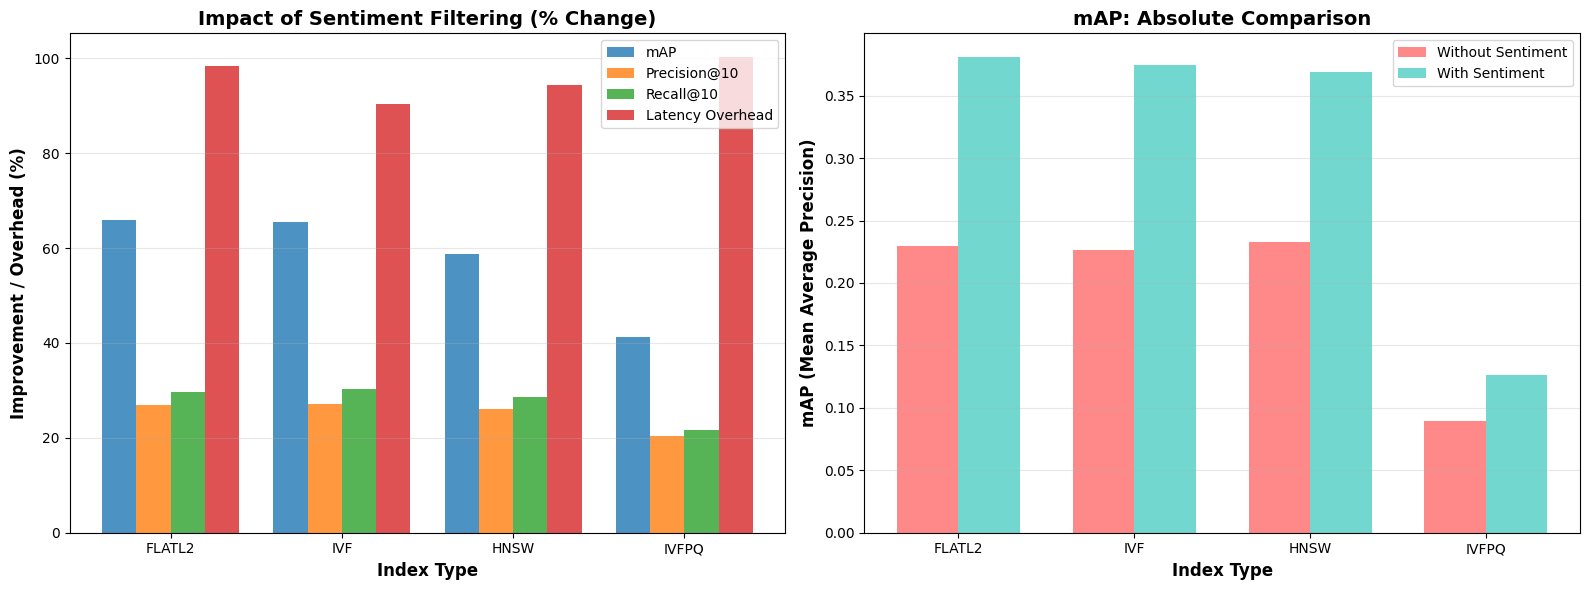


Ablation study visualization saved as 'ablation_study.png'


In [ ]:
print("ABLATION STUDY: IMPACT OF SENTIMENT FILTERING")

# Calculate improvements from sentiment filtering
ablation_results = []

for idx_type in ['flatl2', 'ivf', 'hnsw', 'ivfpq']:
    without = results_df[(results_df['approach'] == 'without_sentiment') &
                         (results_df['index_type'] == idx_type)].iloc[0]
    with_sent = results_df[(results_df['approach'] == 'with_sentiment') &
                           (results_df['index_type'] == idx_type)].iloc[0]

    # Calculate percentage improvements
    map_improvement = ((with_sent['mAP'] - without['mAP']) / without['mAP']) * 100
    mrr_improvement = ((with_sent['MRR'] - without['MRR']) / without['MRR']) * 100
    p10_improvement = ((with_sent['Precision@10'] - without['Precision@10']) / without['Precision@10']) * 100
    r10_improvement = ((with_sent['Recall@10'] - without['Recall@10']) / without['Recall@10']) * 100
    latency_overhead = ((with_sent['avg_latency_ms'] - without['avg_latency_ms']) / without['avg_latency_ms']) * 100

    ablation_results.append({
        'Index': idx_type.upper(),
        'mAP_improvement_%': map_improvement,
        'MRR_improvement_%': mrr_improvement,
        'Precision@10_improvement_%': p10_improvement,
        'Recall@10_improvement_%': r10_improvement,
        'Latency_overhead_%': latency_overhead,
        'Without_mAP': without['mAP'],
        'With_mAP': with_sent['mAP'],
        'Without_Precision@10': without['Precision@10'],
        'With_Precision@10': with_sent['Precision@10']
    })

ablation_df = pd.DataFrame(ablation_results)

print("\nIMPACT OF SENTIMENT FILTERING (% Change)")
print("-" * 80)
print(ablation_df[['Index', 'mAP_improvement_%', 'MRR_improvement_%',
                   'Precision@10_improvement_%', 'Recall@10_improvement_%',
                   'Latency_overhead_%']].to_string(index=False))

print("KEY FINDINGS")

# Find best performing index with sentiment
best_with_sentiment = results_df[results_df['approach'] == 'with_sentiment'].loc[
    results_df[results_df['approach'] == 'with_sentiment']['mAP'].idxmax()
]

print(f"\n1. BEST INDEX WITH SENTIMENT FILTERING:")
print(f"   Index: {best_with_sentiment['index_type'].upper()}")
print(f"   mAP: {best_with_sentiment['mAP']:.4f}")
print(f"   Precision@10: {best_with_sentiment['Precision@10']:.4f}")
print(f"   Latency: {best_with_sentiment['avg_latency_ms']:.2f} ms")

# Average improvements
avg_map_improvement = ablation_df['mAP_improvement_%'].mean()
avg_p10_improvement = ablation_df['Precision@10_improvement_%'].mean()
avg_latency_overhead = ablation_df['Latency_overhead_%'].mean()

print(f"\n2. AVERAGE IMPROVEMENTS FROM SENTIMENT FILTERING:")
print(f"   mAP improvement: {avg_map_improvement:+.2f}%")
print(f"   Precision@10 improvement: {avg_p10_improvement:+.2f}%")
print(f"   Latency overhead: {avg_latency_overhead:+.2f}%")

# Best improvement
best_improvement_idx = ablation_df.loc[ablation_df['mAP_improvement_%'].idxmax(), 'Index']
best_improvement_val = ablation_df['mAP_improvement_%'].max()

print(f"\n3. LARGEST mAP IMPROVEMENT:")
print(f"   Index: {best_improvement_idx}")
print(f"   Improvement: {best_improvement_val:+.2f}%")

# Visualization of ablation study
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Improvement percentages
ax = axes[0]
x_pos = np.arange(len(ablation_df))
width = 0.2

ax.bar(x_pos - width*1.5, ablation_df['mAP_improvement_%'], width,
       label='mAP', color='#1f77b4', alpha=0.8)
ax.bar(x_pos - width*0.5, ablation_df['Precision@10_improvement_%'], width,
       label='Precision@10', color='#ff7f0e', alpha=0.8)
ax.bar(x_pos + width*0.5, ablation_df['Recall@10_improvement_%'], width,
       label='Recall@10', color='#2ca02c', alpha=0.8)
ax.bar(x_pos + width*1.5, ablation_df['Latency_overhead_%'], width,
       label='Latency Overhead', color='#d62728', alpha=0.8)

ax.set_xlabel('Index Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Improvement / Overhead (%)', fontsize=12, fontweight='bold')
ax.set_title('Impact of Sentiment Filtering (% Change)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(ablation_df['Index'])
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(axis='y', alpha=0.3)

# Plot 2: Absolute mAP comparison
ax = axes[1]
x_pos = np.arange(len(ablation_df))
width = 0.35

ax.bar(x_pos - width/2, ablation_df['Without_mAP'], width,
       label='Without Sentiment', color='#FF6B6B', alpha=0.8)
ax.bar(x_pos + width/2, ablation_df['With_mAP'], width,
       label='With Sentiment', color='#4ECDC4', alpha=0.8)

ax.set_xlabel('Index Type', fontsize=12, fontweight='bold')
ax.set_ylabel('mAP (Mean Average Precision)', fontsize=12, fontweight='bold')
ax.set_title('mAP: Absolute Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(ablation_df['Index'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('ablation_study.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAblation study visualization saved as 'ablation_study.png'")

# Cell 10A: Query Testing Without Sentiment

In [ ]:
print("TESTING: 5 QUERIES × 4 INDEXES")

test_queries = [
    "This movie was absolutely fantastic and emotionally powerful",
    "Terrible waste of time, boring and poorly acted",
    "The cinematography was stunning but the plot was confusing",
    "I laughed so hard, best comedy I've seen in years",
    "Disappointing ending ruined an otherwise decent film"
]

index_types = ['flatl2', 'ivf', 'hnsw', 'ivfpq']

# APPROACH A: WITHOUT SENTIMENT FILTERING
print("\nAPPROACH A: WITHOUT SENTIMENT FILTERING")

for query_idx, query in enumerate(test_queries, 1):
    print(f"\n{'='*80}")
    print(f"QUERY {query_idx}: \"{query}\"")
    print(f"{'='*80}")

    for idx_type in index_types:
        print(f"\n{'-'*80}")
        print(f"INDEX: {idx_type.upper()}")
        print(f"{'-'*80}")

        results, latency, retrieved_indices = retrieve_reviews_without_sentiment(
            query,
            k=5,
            index_type=idx_type
        )

        # Show metrics
        pos_count = (results['sentiment'] == 'positive').sum()
        neg_count = (results['sentiment'] == 'negative').sum()
        avg_score = results['similarity_score'].mean()

        print(f"Latency: {latency*1000:.2f} ms")
        print(f"Sentiment Distribution: {pos_count} Positive, {neg_count} Negative")
        print(f"Average Cosine Similarity: {avg_score:.4f}")
        print(f"\nTop 5 Retrieved Reviews:")

        for idx, row in results.iterrows():
            print(f"\n  [{row['rank']}] {row['sentiment'].upper():8s} | Cosine Similarity: {row['similarity_score']:.4f}")
            print(f"      Review: {row['review_clean'][:120]}...")

print("TESTING COMPLETE: 5 QUERIES × 4 INDEXES = 20 RETRIEVALS")

TESTING: 5 QUERIES × 4 INDEXES

APPROACH A: WITHOUT SENTIMENT FILTERING

QUERY 1: "This movie was absolutely fantastic and emotionally powerful"

--------------------------------------------------------------------------------
INDEX: FLATL2
--------------------------------------------------------------------------------
Latency: 14.87 ms
Sentiment Distribution: 5 Positive, 0 Negative
Average Cosine Similarity: 0.6411

Top 5 Retrieved Reviews:

  [1] POSITIVE | Cosine Similarity: 0.6543
      Review: I really enjoyed this movie. It challenged my emotions and beliefs, making it a true piece of artwork in my book. The ac...

  [2] POSITIVE | Cosine Similarity: 0.6474
      Review: This movie is an incredible piece of work. It explores every nook and cranny of the human mind, focusing on the characte...

  [3] POSITIVE | Cosine Similarity: 0.6363
      Review: I watched the movie yesterday and for me it was a stunning combination of movies like Pulp Fiction and Reservoir Dogs. T...

  [4] 

# Cell 10B: Query Testing With Sentiment

In [ ]:
print("TESTING: 5 QUERIES × 4 INDEXES")

test_queries = [
    "This movie was absolutely fantastic and emotionally powerful",
    "Terrible waste of time, boring and poorly acted",
    "The cinematography was stunning but the plot was confusing",
    "I laughed so hard, best comedy I've seen in years",
    "Disappointing ending ruined an otherwise decent film"
]

index_types = ['flatl2', 'ivf', 'hnsw', 'ivfpq']

# APPROACH B: WITH SENTIMENT FILTERING
print("APPROACH B: WITH SENTIMENT FILTERING")

for query_idx, query in enumerate(test_queries, 1):
    print(f"\n{'='*80}")
    print(f"QUERY {query_idx}: \"{query}\"")
    print(f"{'='*80}")

    # Infer sentiment for this query
    inferred_sent = infer_query_sentiment(query)
    sent_result = sentiment_classifier(query[:2000], truncation=True, max_length=512)[0]

    print(f"\nInferred Sentiment: {inferred_sent.upper()} (Confidence: {sent_result['score']:.1%})")
    print(f"System will retrieve only {inferred_sent.upper()} reviews\n")

    for idx_type in index_types:
        print(f"\n{'-'*80}")
        print(f"INDEX: {idx_type.upper()}")
        print(f"{'-'*80}")

        results, latency, detected_sentiment, confidence, retrieved_indices = retrieve_reviews_with_sentiment(
            query,
            k=5,
            index_type=idx_type
        )

        # Show metrics
        pos_count = (results['sentiment'] == 'positive').sum()
        neg_count = (results['sentiment'] == 'negative').sum()
        avg_score = results['similarity_score'].mean()

        print(f"Latency: {latency*1000:.2f} ms")
        print(f"Sentiment Distribution: {pos_count} Positive, {neg_count} Negative")
        print(f"Average Cosine Similarity: {avg_score:.4f}")
        print(f"\nTop 5 Retrieved Reviews:")

        for idx, row in results.iterrows():
            print(f"\n  [{row['rank']}] {row['sentiment'].upper():8s} | Cosine Similarity: {row['similarity_score']:.4f}")
            print(f"      Review: {row['review_clean'][:120]}...")

print("TESTING COMPLETE: 5 QUERIES × 4 INDEXES × 2 APPROACHES = 40 RETRIEVALS")

TESTING: 5 QUERIES × 4 INDEXES
APPROACH B: WITH SENTIMENT FILTERING

QUERY 1: "This movie was absolutely fantastic and emotionally powerful"

Inferred Sentiment: POSITIVE (Confidence: 100.0%)
System will retrieve only POSITIVE reviews


--------------------------------------------------------------------------------
INDEX: FLATL2
--------------------------------------------------------------------------------
Latency: 16.29 ms
Sentiment Distribution: 5 Positive, 0 Negative
Average Cosine Similarity: 0.6411

Top 5 Retrieved Reviews:

  [1] POSITIVE | Cosine Similarity: 0.6543
      Review: I really enjoyed this movie. It challenged my emotions and beliefs, making it a true piece of artwork in my book. The ac...

  [2] POSITIVE | Cosine Similarity: 0.6474
      Review: This movie is an incredible piece of work. It explores every nook and cranny of the human mind, focusing on the characte...

  [3] POSITIVE | Cosine Similarity: 0.6363
      Review: I watched the movie yesterday and for me

# Cell 11: Streamlit Dashboard


In [ ]:
!pip install -q streamlit pyngrok
!npm install -g localtunnel

print("Streamlit and ngrok installed successfully")

dashboard_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import faiss
import pickle
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import time
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime

# PAGE CONFIGURATION

st.set_page_config(
    page_title="Sentiment-Aware Review Finder",
    page_icon="🎬",
    layout="wide",
    initial_sidebar_state="expanded"
)

# CUSTOM CSS STYLING (FINAL)

st.markdown("""
<style>
    /* Main background - Light gradient */
    .main {
        background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
    }

    /* Sidebar styling */
    [data-testid="stSidebar"] {
        background: linear-gradient(180deg, #1e3a8a 0%, #1e40af 100%);
    }

    [data-testid="stSidebar"] * {
        color: white !important;
    }

    /* Fix selectbox text visibility */
    [data-testid="stSidebar"] .stSelectbox > div > div {
        background-color: white !important;
        color: #1e293b !important;
    }

    [data-testid="stSidebar"] .stSelectbox option {
        background-color: white !important;
        color: #1e293b !important;
    }

    /* Card styling */
    .metric-card {
        background: white;
        padding: 25px;
        border-radius: 15px;
        box-shadow: 0 4px 12px rgba(0,0,0,0.1);
        margin: 10px 0;
        border-left: 5px solid #3b82f6;
    }

    .metric-card h4 {
        color: #1e40af !important;
        margin: 0 0 10px 0 !important;
        font-size: 14px !important;
        font-weight: 600 !important;
    }

    .metric-card h2 {
        color: #1e293b !important;
        margin: 5px 0 !important;
        font-size: 32px !important;
    }

    .metric-card p {
        color: #64748b !important;
        margin: 5px 0 0 0 !important;
        font-size: 14px !important;
    }

    /* Result card */
    .result-card {
        background: white;
        padding: 25px;
        border-radius: 12px;
        box-shadow: 0 2px 8px rgba(0,0,0,0.08);
        margin: 15px 0;
        border-top: 4px solid #3b82f6;
        transition: all 0.3s;
    }

    .result-card:hover {
        transform: translateY(-3px);
        box-shadow: 0 6px 16px rgba(0,0,0,0.12);
    }

    .result-card .rank-badge {
        background: linear-gradient(135deg, #3b82f6 0%, #1e40af 100%);
        color: white;
        padding: 8px 16px;
        border-radius: 20px;
        font-weight: 700;
        font-size: 20px;
        display: inline-block;
    }

    .result-card .review-text {
        color: #1e293b !important;
        font-size: 15px !important;
        line-height: 1.7 !important;
        margin: 15px 0 0 0 !important;
    }

    /* Headers */
    h1 {
        color: #1e293b !important;
        font-family: "Helvetica Neue", sans-serif;
        font-weight: 800;
        text-shadow: 2px 2px 4px rgba(0,0,0,0.1);
    }

    h2, h3 {
        color: #1e40af !important;
        font-family: "Helvetica Neue", sans-serif;
    }

    /* Buttons */
    .stButton>button {
        background: linear-gradient(90deg, #3b82f6 0%, #1e40af 100%);
        color: white;
        border: none;
        border-radius: 8px;
        padding: 12px 24px;
        font-weight: 600;
        font-size: 15px;
        box-shadow: 0 4px 12px rgba(59, 130, 246, 0.3);
        transition: all 0.3s;
    }

    .stButton>button:hover {
        transform: translateY(-2px);
        box-shadow: 0 6px 16px rgba(59, 130, 246, 0.4);
    }

    /* Text input */
    .stTextInput>div>div>input, .stTextArea>div>div>textarea {
        border-radius: 8px;
        border: 2px solid #3b82f6;
        padding: 12px;
        font-size: 15px;
        background: white;
        color: #1e293b;
    }

    /* Sentiment badges */
    .sentiment-positive {
        background: #10b981;
        color: white;
        padding: 6px 16px;
        border-radius: 20px;
        font-weight: 600;
        font-size: 14px;
        display: inline-block;
    }

    .sentiment-negative {
        background: #ef4444;
        color: white;
        padding: 6px 16px;
        border-radius: 20px;
        font-weight: 600;
        font-size: 14px;
        display: inline-block;
    }

    /* Score badge */
    .score-badge {
        background: linear-gradient(135deg, #8b5cf6 0%, #6366f1 100%);
        color: white;
        padding: 8px 16px;
        border-radius: 20px;
        font-weight: 700;
        font-size: 16px;
        display: inline-block;
    }

    /* Welcome box */
    .welcome-box {
        background: white;
        border-radius: 20px;
        padding: 40px;
        box-shadow: 0 4px 16px rgba(0,0,0,0.1);
    }

    .welcome-box h2 {
        color: #1e40af !important;
        font-size: 2.2em !important;
    }

    .welcome-box p {
        color: #475569 !important;
        font-size: 1.1em !important;
        line-height: 1.8 !important;
    }

    .feature-box {
        background: #f8fafc;
        padding: 20px;
        border-radius: 10px;
        border-left: 4px solid #3b82f6;
    }

    .feature-box h4 {
        color: #1e40af !important;
        margin-bottom: 8px !important;
    }

    .feature-box p {
        color: #64748b !important;
        margin: 0 !important;
    }

    /* Query box */
    .query-box {
        background: white;
        padding: 20px;
        border-radius: 12px;
        box-shadow: 0 2px 8px rgba(0,0,0,0.08);
        margin: 10px 0;
        border-left: 4px solid #8b5cf6;
    }

    .query-box .query-label {
        color: #6366f1;
        font-weight: 600;
        font-size: 14px;
        margin-bottom: 8px;
    }

    .query-box .query-text {
        color: #1e293b;
        font-size: 15px;
        font-style: italic;
    }
</style>
""", unsafe_allow_html=True)

# LOAD MODELS AND DATA

@st.cache_resource
def load_resources():
    """Load all models, indexes, and data"""

    # Load embedding model
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

    # Load sentiment classifier
    sentiment_classifier = pipeline(
        "sentiment-analysis",
        model="distilbert-base-uncased-finetuned-sst-2-english",
        device=-1
    )

    # Load FAISS indexes
    indexes = {
        "flatl2": faiss.read_index("faiss_flat.index"),
        "ivf": faiss.read_index("faiss_ivf.index"),
        "hnsw": faiss.read_index("faiss_hnsw.index"),
        "ivfpq": faiss.read_index("faiss_ivfpq.index")
    }

    # Load embeddings
    embeddings_normalized = np.load("embeddings_normalized.npy")

    # Load dataframe
    df = pd.read_csv("reviews_processed.csv")

    return embedding_model, sentiment_classifier, indexes, embeddings_normalized, df

# Load everything
with st.spinner("🚀 Loading AI models and data..."):
    embedding_model, sentiment_classifier, indexes, embeddings_normalized, df = load_resources()

# RETRIEVAL FUNCTION

def search_reviews(query_text, k, index_type, filter_by_sentiment):
    """Main search function"""
    start_time = time.time()

    # Truncate query
    query_text = query_text[:2000] if len(query_text) > 2000 else query_text

    # Infer sentiment
    sentiment_result = sentiment_classifier(query_text, truncation=True, max_length=512)[0]
    inferred_sentiment = sentiment_result["label"].lower()
    sentiment_confidence = sentiment_result["score"]
    sentiment_label = 1 if inferred_sentiment == "positive" else 0

    # Encode query
    query_embedding = embedding_model.encode([query_text], convert_to_numpy=True)
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # Select index
    index = indexes[index_type]

    # Search
    if filter_by_sentiment:
        search_k = min(k * 10, len(df))
        distances, indices = index.search(query_embedding, search_k)

        # Filter by sentiment
        retrieved_sentiments = df.iloc[indices[0]]["sentiment_label"].values
        mask = retrieved_sentiments == sentiment_label
        filtered_indices = indices[0][mask][:k]
        filtered_distances = distances[0][mask][:k]
    else:
        distances, indices = index.search(query_embedding, k)
        filtered_indices = indices[0]
        filtered_distances = distances[0]

    query_time = time.time() - start_time

    # Prepare results with cosine similarity
    results_df = df.iloc[filtered_indices][["review_clean", "sentiment", "sentiment_label"]].copy()
    results_df["similarity_score"] = 1 - (filtered_distances / 2)  # Convert to cosine similarity
    results_df["rank"] = range(1, len(results_df) + 1)
    results_df = results_df.reset_index(drop=True)

    return results_df, query_time, inferred_sentiment, sentiment_confidence

# HEADER

st.markdown("<h1 style=\\'text-align: center; font-size: 3em; margin-bottom: 10px;\\'>🎬 Sentiment-Aware Review Finder</h1>", unsafe_allow_html=True)
st.markdown("<p style=\\'text-align: center; color: #475569; font-size: 1.1em; margin-bottom: 30px;\\'>Advanced Vector Database Retrieval System | IMDB Movie Reviews</p>", unsafe_allow_html=True)

# SIDEBAR

st.sidebar.markdown("### ⚙️ Configuration")

# Number of results (1-30)
k = st.sidebar.slider(
    "📊 Number of Results",
    min_value=1,
    max_value=30,
    value=5,
    step=1,
    help="How many reviews to retrieve (1-30)"
)

# Index selection
index_type = st.sidebar.selectbox(
    "🔍 Search Index",
    ["flatl2", "ivf", "hnsw", "ivfpq"],
    format_func=lambda x: {
        "flatl2": "FlatL2 (Exact Search)",
        "ivf": "IVF (Fast Approximate)",
        "hnsw": "HNSW (Hierarchical)",
        "ivfpq": "IVF+PQ (Compressed)"
    }[x],
    help="Choose the FAISS index type"
)

# Sentiment filtering
filter_sentiment = st.sidebar.checkbox(
    "🎭 Enable Sentiment Filtering",
    value=True,
    help="Filter results by query sentiment"
)

st.sidebar.markdown("---")

# System stats
st.sidebar.markdown("### 📈 System Statistics")
st.sidebar.metric("Total Reviews", f"{len(df):,}")
st.sidebar.metric("Embedding Dimension", "384")
st.sidebar.metric("Active Index", index_type.upper())

st.sidebar.markdown("---")
st.sidebar.markdown("### 🎓 About")
st.sidebar.info("""
**Sentiment-Aware Review Finder**

This system uses:
- 🤖 SentenceTransformers for embeddings
- 🔎 FAISS for vector search
- 🎭 DistilBERT for sentiment analysis
- 📊 4 different index types

""")

# MAIN CONTENT - MULTIPLE QUERY INPUT

st.markdown("### 🔍 Enter Your Queries")
st.markdown("You can enter multiple queries at once (one per line) or use the single query input below.")

# Tab selection
tab1, tab2 = st.tabs(["📝 Single Query", "📋 Multiple Queries"])

queries_to_search = []

with tab1:
    st.markdown("**Enter a single movie review query:**")
    single_query = st.text_input(
        "",
        placeholder="e.g., This movie was amazing and emotional",
        label_visibility="collapsed",
        key="single_query"
    )

    if single_query:
        queries_to_search = [single_query]

with tab2:
    st.markdown("**Enter multiple queries (one per line):**")
    multi_queries = st.text_area(
        "",
        placeholder="This movie was amazing\\nTerrible waste of time\\nGreat cinematography but weak plot",
        height=150,
        label_visibility="collapsed",
        key="multi_queries"
    )

    if multi_queries:
        queries_to_search = [q.strip() for q in multi_queries.split("\\n") if q.strip()]

# Search button
search_col1, search_col2, search_col3 = st.columns([1, 2, 1])
with search_col2:
    search_button = st.button("🚀 Search All Queries", use_container_width=True, type="primary")

# SEARCH EXECUTION

if queries_to_search and search_button:

    st.markdown("---")
    st.markdown(f"### 📊 Processing {len(queries_to_search)} {'Query' if len(queries_to_search) == 1 else 'Queries'}")

    # Process each query
    for query_idx, query in enumerate(queries_to_search, 1):

        st.markdown(f"""
        <div class="query-box">
            <div class="query-label">Query {query_idx} of {len(queries_to_search)}</div>
            <div class="query-text">"{query}"</div>
        </div>
        """, unsafe_allow_html=True)

        with st.spinner(f"🔎 Searching query {query_idx}..."):
            results, latency, sentiment, confidence = search_reviews(
                query, k, index_type, filter_sentiment
            )

        # Metrics row
        metric_col1, metric_col2, metric_col3, metric_col4 = st.columns(4)

        with metric_col1:
            st.markdown(f"""
            <div class="metric-card">
                <h4>⏱️ Query Time</h4>
                <h2>{latency*1000:.2f} ms</h2>
            </div>
            """, unsafe_allow_html=True)

        with metric_col2:
            sentiment_color = "#10b981" if sentiment == "positive" else "#ef4444"
            st.markdown(f"""
            <div class="metric-card">
                <h4>🎭 Detected Sentiment</h4>
                <h2 style="color: {sentiment_color} !important;">{sentiment.upper()}</h2>
                <p>{confidence:.1%} confidence</p>
            </div>
            """, unsafe_allow_html=True)

        with metric_col3:
            st.markdown(f"""
            <div class="metric-card">
                <h4>📝 Results Found</h4>
                <h2>{len(results)}</h2>
            </div>
            """, unsafe_allow_html=True)

        with metric_col4:
            avg_similarity = results["similarity_score"].mean()
            st.markdown(f"""
            <div class="metric-card">
                <h4>📊 Avg Similarity</h4>
                <h2>{avg_similarity:.3f}</h2>
            </div>
            """, unsafe_allow_html=True)

        # Results
        st.markdown(f"#### 🎯 Top {k} Results for Query {query_idx}")

        # Create expandable sections for better organization with many results
        with st.expander(f"View all {len(results)} results", expanded=True):
            for idx, row in results.iterrows():
                sentiment_class = "sentiment-positive" if row["sentiment"] == "positive" else "sentiment-negative"
                sentiment_emoji = "😊" if row["sentiment"] == "positive" else "😞"

                st.markdown(f"""
                <div class="result-card">
                    <div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 15px;">
                        <div>
                            <span class="rank-badge">#{row["rank"]}</span>
                            <span class="{sentiment_class}" style="margin-left: 15px;">{sentiment_emoji} {row["sentiment"].upper()}</span>
                        </div>
                        <span class="score-badge">Similarity: {row["similarity_score"]:.3f}</span>
                    </div>
                    <p class="review-text">
                        {row["review_clean"][:400]}{"..." if len(row["review_clean"]) > 400 else ""}
                    </p>
                </div>
                """, unsafe_allow_html=True)

        # Separator between queries
        if query_idx < len(queries_to_search):
            st.markdown("---")

elif not queries_to_search and search_button:
    st.warning("⚠️ Please enter at least one query")

else:
    # Welcome screen
    st.markdown("---")
    st.markdown("""
    <div class="welcome-box">
        <h2 style="text-align: center; margin-bottom: 20px;">👋 Welcome to Sentiment-Aware Review Finder</h2>
        <p style="text-align: center;">
            Enter movie review queries above to find semantically similar reviews from the IMDB dataset.<br>
            Our AI-powered system uses advanced vector search and sentiment analysis to deliver accurate results.
        </p>
        <div style="margin-top: 40px;">
            <h3 style="color: #1e40af; text-align: center;">🚀 Key Features</h3>
            <div style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 20px; margin-top: 20px;">
                <div class="feature-box">
                    <h4>🔍 Semantic Search</h4>
                    <p>Find reviews based on meaning, not just keywords</p>
                </div>
                <div class="feature-box">
                    <h4>🎭 Sentiment Analysis</h4>
                    <p>Automatic detection and filtering by sentiment</p>
                </div>
                <div class="feature-box">
                    <h4>📋 Multiple Queries</h4>
                    <p>Process multiple queries at once for batch analysis</p>
                </div>
                <div class="feature-box">
                    <h4>⚡ Multiple Indexes</h4>
                    <p>Choose from 4 different FAISS index types</p>
                </div>
            </div>
        </div>
    </div>
    """, unsafe_allow_html=True)

# Footer
st.markdown("---")
st.markdown("""
<div style="text-align: center; color: #64748b; padding: 20px;">
    <p style="font-size: 14px;">
        Built with Streamlit • Powered by FAISS & SentenceTransformers<br>
        CSE488 Project • Vector Database Implementation
    </p>
</div>
""", unsafe_allow_html=True)
'''

# Write to file
with open('app.py', 'w') as f:
    f.write(dashboard_code)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.7 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦
added 22 packages in 2s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧npm notice
npm notice New major version of npm available! 10.8.2 -> 11.7.0
npm notice Changelog: https://github.com/npm/cli/releases/tag/v11.7.0
npm notice To update run: npm install -g npm@11.7.0
npm notice
⠧Streamlit and ngrok installed successfully


In [ ]:
# Save FAISS indexes
faiss.write_index(indexes['flatl2'], 'faiss_flat.index')
faiss.write_index(indexes['ivf'], 'faiss_ivf.index')
faiss.write_index(indexes['hnsw'], 'faiss_hnsw.index')
faiss.write_index(indexes['ivfpq'], 'faiss_ivfpq.index')

# Save embeddings
np.save('embeddings_normalized.npy', embeddings_train_normalized)

# Save dataframe
train_df[['review_clean', 'sentiment', 'sentiment_label']].to_csv('reviews_processed.csv', index=False)

print("All files saved for dashboard:")
print("  - faiss_flat.index")
print("  - faiss_ivf.index")
print("  - faiss_hnsw.index")
print("  - faiss_ivfpq.index")
print("  - embeddings_normalized.npy")
print("  - reviews_processed.csv")
print("  - app.py")

All files saved for dashboard:
  - faiss_flat.index
  - faiss_ivf.index
  - faiss_hnsw.index
  - faiss_ivfpq.index
  - embeddings_normalized.npy
  - reviews_processed.csv
  - app.py


In [ ]:
from pyngrok import ngrok, conf
import time
NGROK_AUTH_TOKEN = "35BZCo1tuNfNArQBZg2xGuqPaLX_3okvagAZkt1jvfxF9XERJ"
conf.get_default().auth_token = NGROK_AUTH_TOKEN
!pkill -f streamlit
print("Starting Streamlit server...")
!streamlit run app.py &>/dev/null &
time.sleep(10)

print("\nCreating ngrok tunnel...")
public_url = ngrok.connect(8501)

print("DASHBOARD IS LIVE!")
print(f"\nPublic URL: {public_url}")
print(f"\nAlternative: {public_url.public_url}")
print("\nTips:")
print("  - Click the URL above to open the dashboard")
print("  - Share the URL with others to let them access it")
print("  - Keep this cell running - stopping it will close the tunnel")
print("  - The tunnel will stay active as long as this notebook is running")
print("\nTo stop: Interrupt this cell or restart the kernel")

# Keep the tunnel alive
try:
    print("\nTunnel is running. Press 'Stop' button to terminate.")
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("\n\nShutting down...")
    ngrok.kill()
    !pkill -f streamlit
    print("Dashboard stopped")

Starting Streamlit server...

Creating ngrok tunnel...
DASHBOARD IS LIVE!

Public URL: NgrokTunnel: "https://holohedral-bolshevistically-marcelene.ngrok-free.dev" -> "http://localhost:8501"

Alternative: https://holohedral-bolshevistically-marcelene.ngrok-free.dev

Tips:
  - Click the URL above to open the dashboard
  - Share the URL with others to let them access it
  - Keep this cell running - stopping it will close the tunnel
  - The tunnel will stay active as long as this notebook is running

To stop: Interrupt this cell or restart the kernel

Tunnel is running. Press 'Stop' button to terminate.


Shutting down...
Dashboard stopped
